<a href="https://colab.research.google.com/github/douglasmasho/MedAlgo/blob/main/MedalgoClassifierKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!unzip "/content/drive/MyDrive/fulldata.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

In [30]:
# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Building Model
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy

# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

In [31]:
# Global variables
SAVE = False
SEED = 111

# Setting seed for consistent results
tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Data Visualization updates
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 14})

# Data Classifications
CLASS_TYPES = ['pituitary', 'notumor', 'meningioma', 'glioma']
N_TYPES = len(CLASS_TYPES)

# Image size
image_size = (150, 150)

# Training batch size
batch_size = 32

In [32]:
import os

def get_data_labels(directory):
    paths = []
    labels = []

    # Iterate over the folders in the directory
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)

        # Check if the path is a directory
        if os.path.isdir(label_path):
            # Iterate over the files in the directory
            for file_name in os.listdir(label_path):
                file_path = os.path.join(label_path, file_name)

                # Add file path and corresponding label
                paths.append(file_path)
                labels.append(label)

    return paths, labels

# Assuming the structure is /content/Training/<label>/<file> and /content/Testing/<label>/<file>
file1 = "/content/Training"
file2 = "/content/Testing"

# Getting data using the function
train_paths, train_labels = get_data_labels(file1)
test_paths, test_labels = get_data_labels(file2)

print('Training Set')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_labels)}')
print('\nTesting Set')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_labels)}')


Training Set
Number of Paths: 5712
Number of Labels: 5712

Testing Set
Number of Paths: 1311
Number of Labels: 1311


In [33]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")


# applying the generator to training data with constant seed
train_generator = train_datagen.flow_from_directory(file1,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    seed=SEED)

# No augmentation of the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# applying the generator to testing data with constant seed
test_generator = test_datagen.flow_from_directory(file2,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=SEED)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [34]:
class_indices_train = train_generator.class_indices
class_indices_train_list = list(train_generator.class_indices.keys())


# Display categorical types
print("Categorical types for the training data:")
print(class_indices_train)

Categorical types for the training data:
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [35]:
# Image shape: height, width, RBG
image_shape = (image_size[0], image_size[1], 3)

# Training epochs
epochs = 50

# Steps per epoch
steps_per_epoch = train_generator.samples // batch_size

# Validation steps
validation_steps = test_generator.samples // batch_size

In [36]:
# Define the model architecture
model = models.Sequential([

    # Convolutional layer 1
    Conv2D(32, (4, 4), activation="relu", input_shape=image_shape),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 2
    Conv2D(64, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 4
    Conv2D(128, (4, 4), activation="relu"),
    Flatten(),

    # Full connect layers
    Dense(512, activation="relu"),
    Dropout(0.5, seed=SEED),
    Dense(N_TYPES, activation="softmax")
])

model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 147, 147, 32)        │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 46, 46, 64)          │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 1, 1, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 495,972 (1.89 MB)

 Trainable params: 495,972 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
!pip install visualkeras

/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


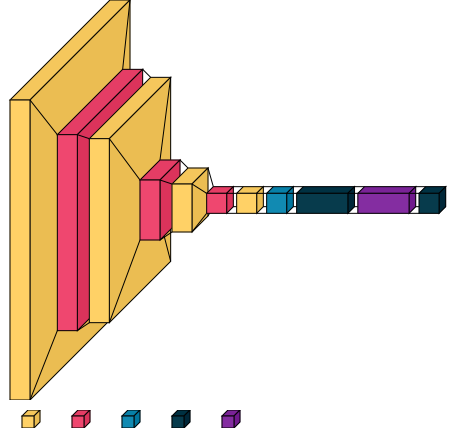

In [38]:
from visualkeras import layered_view

# Visualize the model
layered_view(model, legend=True, max_xy=300)

In [50]:
# Stop training if loss doesn't keep decreasing.
model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=8, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=True)

# Training the model
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=validation_steps,
                    callbacks=[model_es, model_rlr])

Epoch 1/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 44s 237ms/step - accuracy: 0.9743 - loss: 0.0737 - val_accuracy: 0.9633 - val_loss: 0.1197 - learning_rate: 3.0000e-04
Epoch 2/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step - accuracy: 1.0000 - loss: 0.0224 - val_accuracy: 1.0000 - val_loss: 0.0023 - learning_rate: 3.0000e-04
Epoch 3/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 44s 236ms/step - accuracy: 0.9855 - loss: 0.0468 - val_accuracy: 0.9609 - val_loss: 0.1299 - learning_rate: 3.0000e-04
Epoch 4/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - accuracy: 0.9688 - loss: 0.0734 - val_accuracy: 1.0000 - val_loss: 7.7424e-04 - learning_rate: 3.0000e-04
Epoch 5/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 44s 235ms/step - accuracy: 0.9843 - loss: 0.0506 - val_accuracy: 0.9523 - val_loss: 0.1212 - learning_rate: 3.0000e-04
Epoch 6/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step - accuracy: 1.0000 - loss: 0.0244 - val_accuracy: 1.0000 - val_loss: 0.0373 - learning_rate: 3.0000e-04
Epoch 7/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 82s 239ms/step - accuracy: 0.9775 - loss: 0.0609 - val_accuracy: 0.9734 - val_loss: 0.0879 - learning_rate: 3.0000e-04
Epoch 8/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - accuracy: 1.0000 - loss: 0.0081 - val_accuracy: 1.0000 - val_loss: 1.1256e-04 - learning_rate: 3.0000e-04
Epoch 9/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 82s 237ms/st

In [44]:
# Evaluating the model
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples//batch_size)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9220 - loss: 0.2067
Test Loss: 0.17013
Test Accuracy: 0.93437


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step


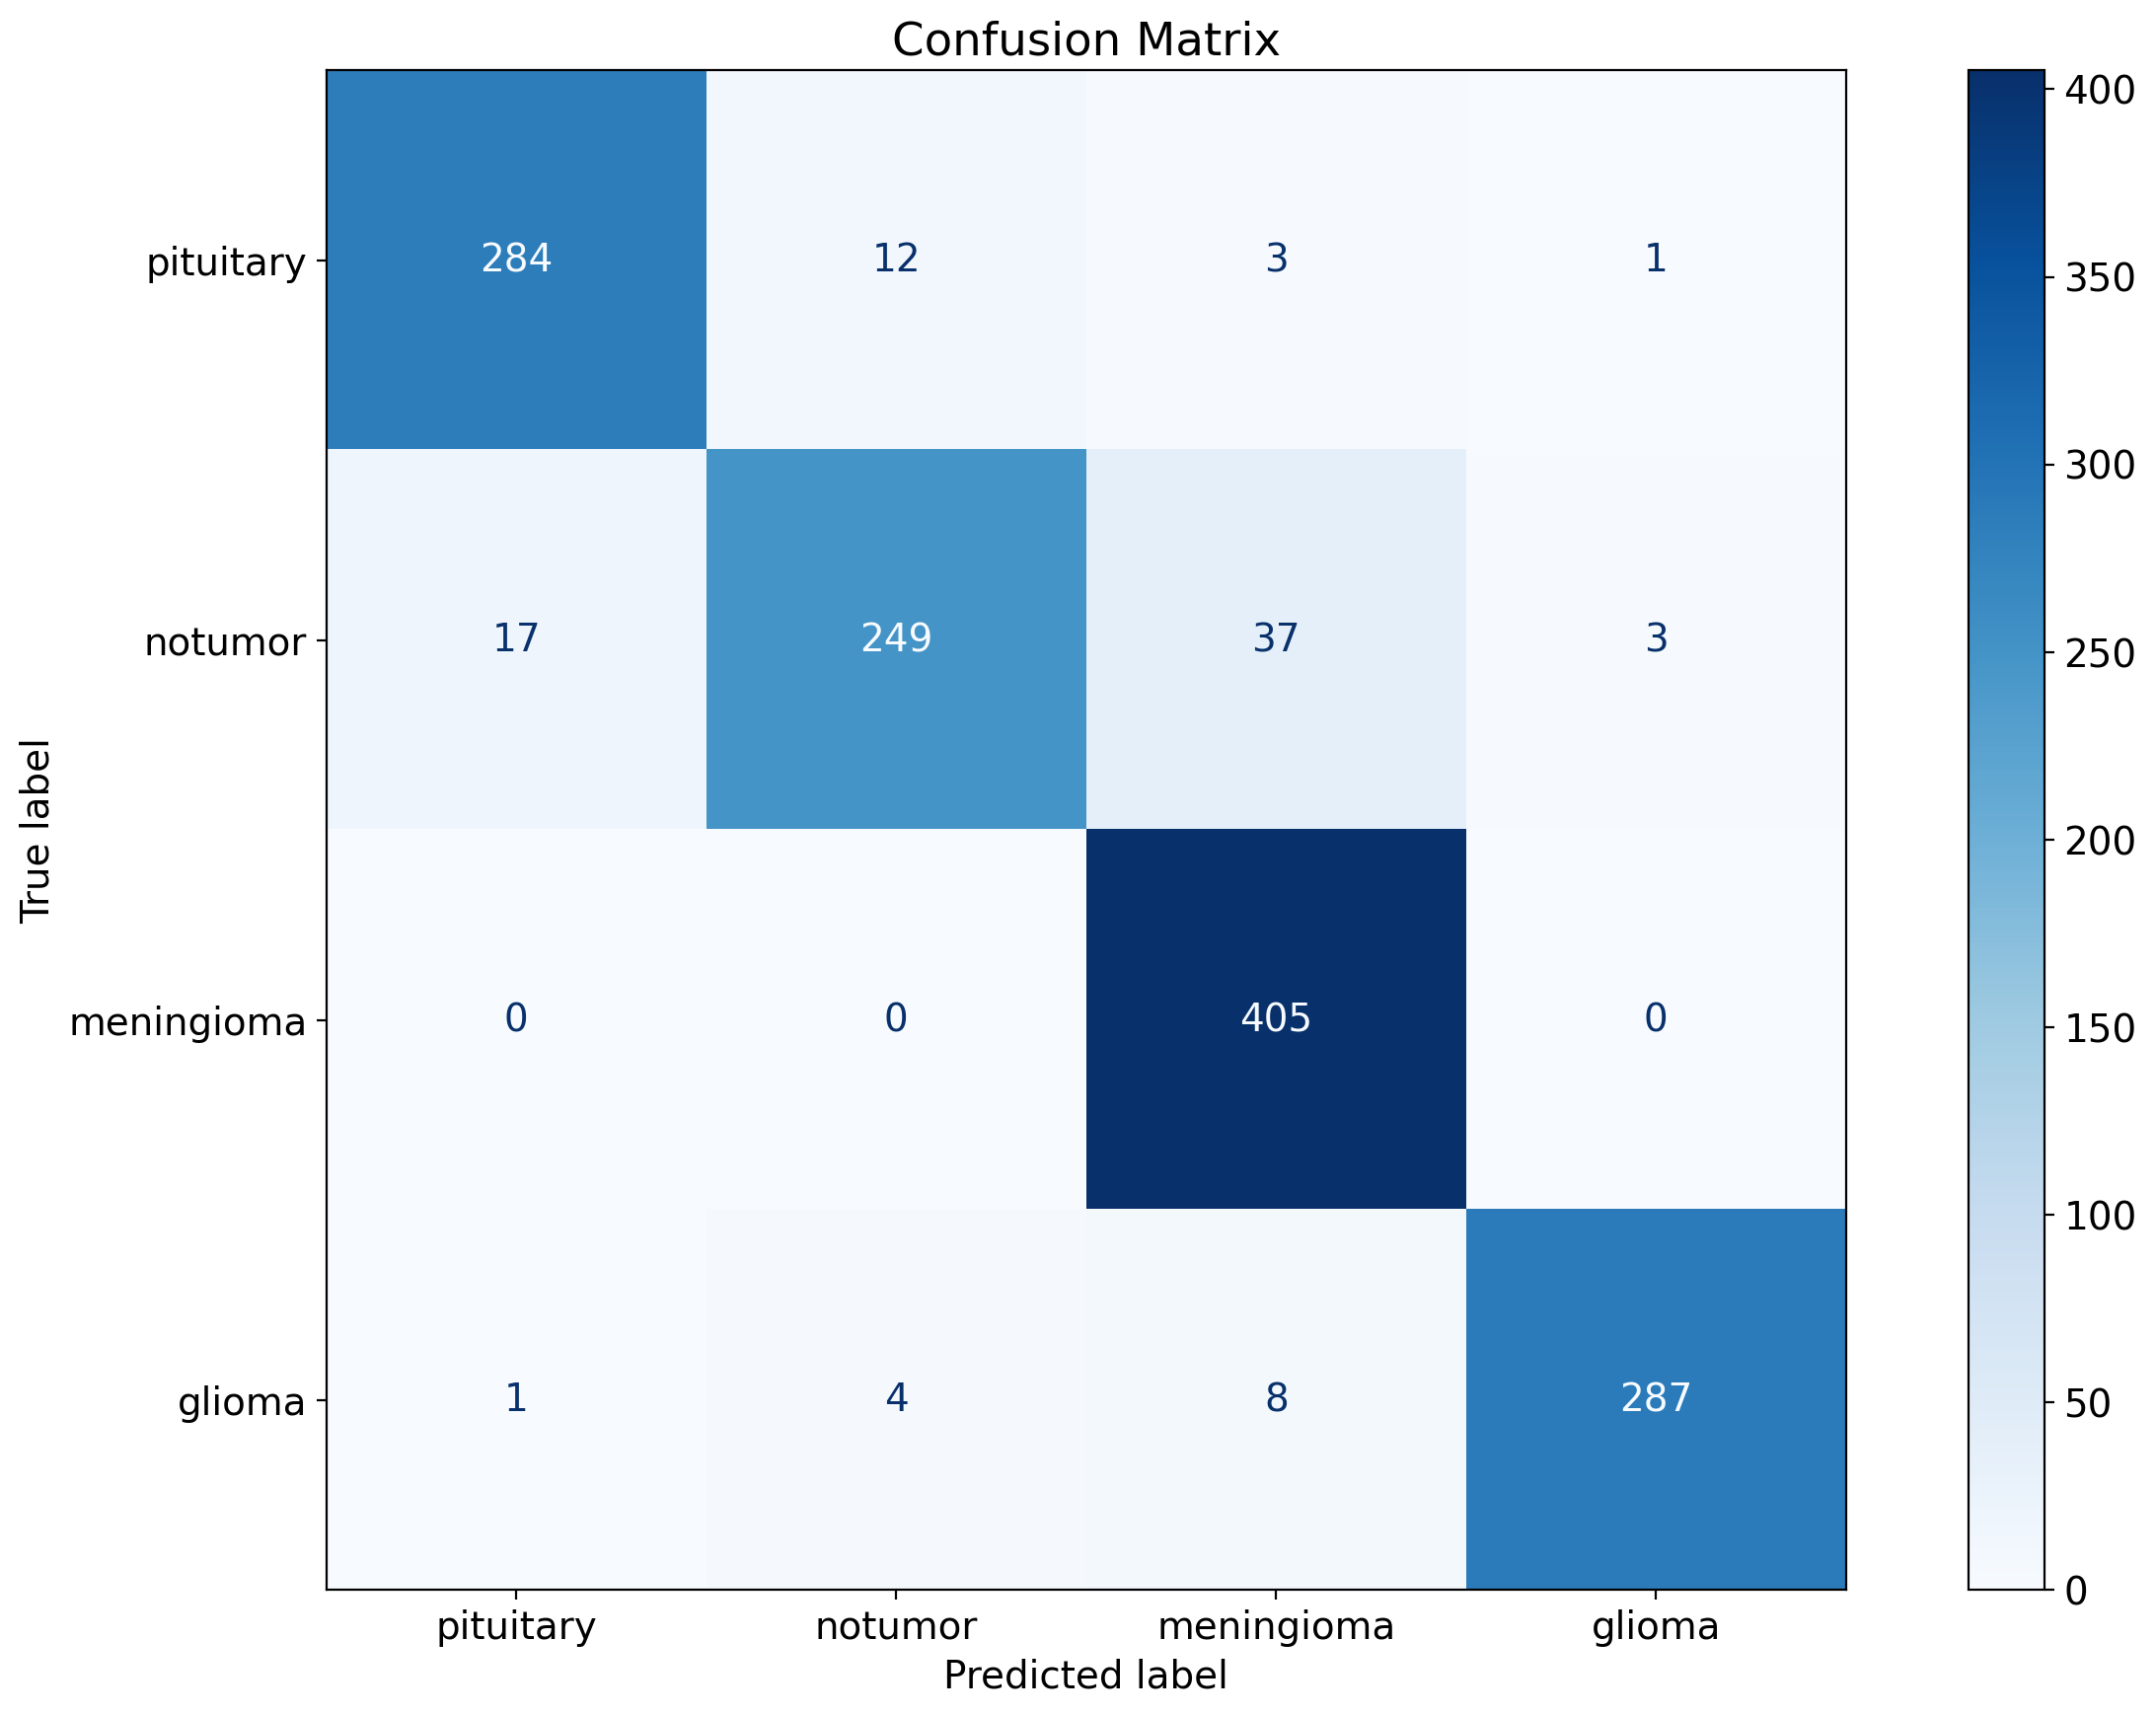

In [45]:
# Step 1: Generate predictions for the test set using all available samples
predictions = model.predict(test_generator, steps=None)  # Use steps=None to process the entire test set

# Step 2: Convert the predictions from probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Step 3: Get the true labels from the test generator
true_classes = test_generator.classes

# Step 4: Create the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Step 5: Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=CLASS_TYPES)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [42]:
model.save("multi-classifier.keras")

In [49]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

class_indices_train_list = ['glioma', 'meningioma', 'notumor', 'pituitary']
# Load the model
# model = tf.keras.models.load_model('/content/drive/MyDrive/multi-classifier.keras')

# Verify the model architecture
model.summary()

# Ensure the input shape is correct
input_shape = model.input_shape[1:]  # Skip the batch size
print(f"Expected input shape: {input_shape}")

def load_and_preprocess_image(img_path, target_size):
    """
    Load and preprocess the MRI image.
    Args:
        img_path (str): Path to the MRI image file.
        target_size (tuple): The target size for the image.

    Returns:
        img_array (numpy.ndarray): Preprocessed image array.
    """
    # Load image
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Normalize the image (assuming normalization was done during training)
    img_array = img_array / 255.0

    return img_array

def predict_image(img_path):
    """
    Predict the class and probabilities for a single MRI image.
    Args:
        img_path (str): Path to the MRI image file.

    Returns:
        predicted_class (str): The predicted class label.
        probabilities (dict): Probabilities for each class.
    """
    # Load and preprocess the image
    img_array = load_and_preprocess_image(img_path, target_size=input_shape[:2])

    # Make a prediction
    predictions = model.predict(img_array)

    # Get the predicted class index and class name
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_indices_train_list[predicted_class_index]  # Ensure `class_indices_train_list` is defined

    # Get probabilities for all classes
    probabilities = {class_name: predictions[0][i] for i, class_name in enumerate(class_indices_train_list)}

    return predicted_class, probabilities

# Example usage
img_path = '/content/Testing/notumor/Te-noTr_0002.jpg'  # Replace with the actual image path
predicted_class, probabilities = predict_image(img_path)
print(f"Predicted Class: {predicted_class}")
print(f"Probabilities: {probabilities}")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 147, 147, 32)        │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 46, 46, 64)          │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 1, 1, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,487,918 (5.68 MB)

 Trainable params: 495,972 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 991,946 (3.78 MB)

Expected input shape: (150, 150, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted Class: notumor
Probabilities: {'glioma': 3.659115e-08, 'meningioma': 6.1482926e-05, 'notumor': 0.9999385, 'pituitary': 2.9510476e-08}
